<a href="https://colab.research.google.com/github/artem-barsov/Numerical-Methods/blob/main/NM_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вычисление несобственных интегралов численными методами

Определённый интеграл называется несобственным, если выполняется по крайней мере одно из следующих условий:
* Область интегрирования является бесконечной. Например, является бесконечным промежутком $[a,+\infty)$.
* Функция $f(x)$ является неограниченной в окрестности некоторых точек области интегрирования.

Если интервал $[a,b]$ конечный и функция интегрируема по Риману, то значение несобственного интеграла совпадает со значением определённого интеграла.

Так как любой несобственный интеграл 2 рода можно свести к решению несобственного интеграла 1 рода с помощью замен переменной, в данной работе будут рассмотрены численные методы решения интегралов 1 рода.



In [ ]:
from math import sqrt, exp, pi, atan
import numpy as np
from sympy import Symbol, Poly, laguerre
import matplotlib.pyplot as plt
INF = 1e8

## Методы вычисления определённого интеграла

In [ ]:
def rectangle_method(f, l, r, h):
    r = l+h*int((r-l)/h)
    x, nx = l, l+h
    res = 0
    while nx <= r or abs(nx-r) < 1e-9:
        res += f((x+nx)/2)
        x, nx = nx, nx+h
    return h * res

In [ ]:
def trapezoidal_method(f, l, r, h):
    r = l+h*int((r-l)/h)
    x = l
    res = 0
    while x <= r or abs(x-r) < 1e-9:
        res += f(x)
        x += h
    return h * (res - (f(l)+f(r))/2)

In [ ]:
def Simpson_method(f, l, r, h):
    r = l+h*int((r-l)/h)
    x = l + h
    res, i = 0, True
    while x <= r or abs(x-r) < 1e-9:
        res += (4 if i else 2) * f(x)
        i = not i
        x += h
    return h / 3 * (f(l) - f(r) + res)

## Методы вычисления несобственного интеграла 1 рода

**Метод с заменой переменной.**

Рассмотрим преобразование, выполненное с помощью замены переменной:

$\int\limits_a^b f(x)dx = \int\limits_\frac{1}{b}^\frac{1}{a} \frac{1}{t^2} f(\frac{1}{t})dt$ при $ab>0$

В силу свойства линейности, можем разложить несобственный интеграл на сумму интегралов:

$\int\limits_{-\infty}^{+\infty}f(x)dx = \int\limits_{-\infty}^{-A}f(x)dx + \int\limits_{-A}^{B}f(x)dx + \int\limits_{B}^{+\infty}f(x)dx$ при $A>0$ и $B>0$

Несобственные  интегралы преобразуем с помощью формулы выше, и вычислим полученные 3 интеграла, например, методами прямоугольников, трапеций или Симпсона.

In [ ]:
def integrate_with_variable_substitution(f, l, r, h=0.01, eps=1e-6, f_integrate=rectangle_method):
    f_new = lambda t: (1 / t**2) * f(1 / t)
    result = 0
    if r >= INF:
        new_r = max(eps, l)
        result += f_integrate(f_new, eps, 1 / new_r - eps, h)
    else:
        new_r = r
    if l <= -INF:
        new_l = min(-eps, r)
        result += f_integrate(f_new, 1 / new_l + eps, -eps, h)
    else:
        new_l = l
    if new_l < new_r:
        result += f_integrate(f, new_l, new_r, h)
    return result

**Квадратурная формула Гаусса — Лагерра** аппроксимирует значения интегралов вида:

$\int\limits_{0}^{+\infty}e^{-x}f(x)dx $

рядом по $n$ точкам

$\int\limits _{0}^{+\infty}e^{-x}f(x)dx \approx \sum\limits_{i=1}^n w_i f(x_i)$

где $x_i$ — это $i$-й корень полинома Лагерра $L_n(x)$, а коэффициенты $w_{i}$:

$w_{i}={\frac {x_{i}}{(n+1)^{2}L_{n+1}^{2}(x_{i})}}$

Для интеграла произвольной функции можно записать:

$\int \limits _{0}^{+\infty }f(x)\,dx=\int \limits _{0}^{+\infty }f(x)e^{x}e^{-x}\,dx=\int \limits _{0}^{+\infty }g(x)e^{-x}\,dx,$

где $g(x)=f(x)e^{x}$.

Далее можно применить квадратурную формулу Гаусса — Лагерра к новой функции $g(x)$.

In [ ]:
def Gauss_Laguerre_quadrature(f, n=5, isGeneralFunction=True):
    def lag_roots_weights(n):
        x = Symbol("x")
        roots = Poly(laguerre(n, x)).all_roots()
        x_i = [rt.evalf(20) for rt in roots]
        w_i = [(rt / ((n + 1) * laguerre(n + 1, rt)) ** 2).evalf(20) for rt in roots]
        return x_i, w_i
    if isGeneralFunction:
        f = lambda x, f=f: f(x) * exp(x)
    x, w = lag_roots_weights(n)
    w = np.array(w)
    f = np.vectorize(f)
    return (w * f(x)).sum()

In [ ]:
def integrate_with_Gauss_Laguerre_quadrature(f, l, r, h=0.01, f_integrate=rectangle_method, n_lag_roots=5, isGeneralFunction=True):
    result = 0
    if r >= INF:
        result += Gauss_Laguerre_quadrature(f, n_lag_roots, isGeneralFunction)
        if l > 0: result -= f_integrate(f, 0, l, h)
    elif r > 0:
        result += f_integrate(f, max(l, 0), r, h)
    if l <= -INF:
        result += Gauss_Laguerre_quadrature(lambda x: f(-x), n_lag_roots, isGeneralFunction)
        if r < 0: result -= f_integrate(f, r, 0, h)
    elif l < 0:
        result += f_integrate(f, l, min(r, 0), h)
    return result

**Предельный переход**

$\int\limits_{a}^{+\infty}f(x)dx = \lim\limits_{b\rightarrow\infty}\int\limits_{a}^{b}f(x)dx \approx \sum\limits_{n=a}^{+\infty}f(nh)$,

где $h$ - заданный шаг численного интегрирования. Суммирование заканчивается, когда остаток ряда меньше заданного $\varepsilon$.

In [ ]:
def integrate_with_limits(f, l, r, h=0.1, eps=1e-6, f_integrate=rectangle_method):
    result = 0
    deltas = [[]]
    iters = 0
    if r >= INF:
        x, nx = max(l, 0), max(l, 0)+h
        while True:
            iters += 1
            d_int = f_integrate(f, x, nx+eps, h)
            result += d_int
            deltas[-1].append(d_int)
            if abs(d_int) < eps: break
            x, nx = nx, nx+h
    else:
        result += f_integrate(f, max(l, 0), r, h)
    
    if l <= -INF:
        deltas.append([])
        x, nx = min(r, 0), min(r, 0)-h
        while True:
            iters += 1
            d_int = f_integrate(f, nx, x+eps, h)
            result += d_int
            deltas[-1].append(d_int)
            if abs(d_int) < eps: break
            x, nx = nx, nx-h
    else:
        result += f_integrate(f, l, min(r, 0), h)

    return result, deltas

## Решение

In [ ]:
f = lambda x: 1 / (x**2 + 1)
ans_exact = pi
a = -INF
b = INF
h = 0.1
eps = 1e-8

In [ ]:
res = integrate_with_variable_substitution(f, a, b, h)
print('Преобразованием в определённый интеграл заменой переменной:', res)
print('Абсолютная погрешность:', abs(ans_exact - res))
print()
res = integrate_with_Gauss_Laguerre_quadrature(f, a, b, h, n_lag_roots=16)
print('С помощью квадратурной формулы Гаусса-Лагерра:', res)
print('Абсолютная погрешность:', abs(ans_exact - res))
print()
res, deltas = integrate_with_limits(f, a, b, h)
print('С помощью предельного перехода:', res)
print('Абсолютная погрешность:', abs(ans_exact - res))
print()

Преобразованием в определённый интеграл заменой переменной: 3.0416804657161816
Абсолютная погрешность: 0.09991218787361156

С помощью квадратурной формулы Гаусса-Лагерра: 3.1074754698652988691
Абсолютная погрешность: 0.034117183724494246946

С помощью предельного перехода: 3.1352695637391474
Абсолютная погрешность: 0.006323089850645669



## Анализ

### Проанализурем зависимость абсолютной погрешности метода с квадратурной формулой Гаусса-Лагерра от количества узлов полинома Лагерра

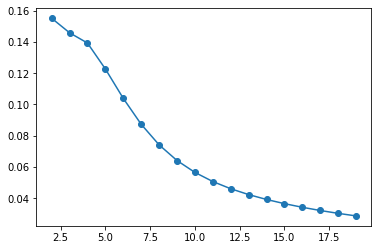

In [ ]:
x = range(2, 20)
y = abs(np.array([ans_exact]*len(x)) - np.vectorize(integrate_with_Gauss_Laguerre_quadrature)(f, a, b, h, n_lag_roots=x))
plt.plot(x, y, marker='o');

### Проанализируем зависимость величины прироста интеграла от номера итерации в методе предельного перехода

Всего 3163 и 3163 итераций


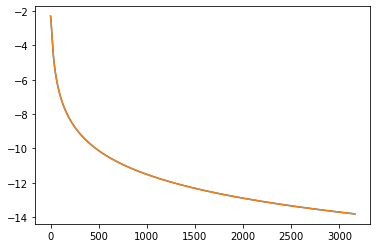

In [ ]:
print(f'Всего {" и ".join([str(len(delta)) for delta in deltas])} итераций')
for delta in deltas:
    plt.plot(np.log(np.abs(delta)))

## Вывод

В данной работе я проанализировал и сравнил 3 метода вычисления несобственных интегралов численными методами. На выбранном примере быстрее всего работал метод предельного перехода, а главное с наименьшей погрешностью. Однако самым универсальным методом оказался метод Гаусса-Лаггера в связке с обычными методами численного интегрирования (методы прямоугольников, трапеций, Симпсона), так как нет риска зависнуть в долгих вычислениях при малых допустимых значений погрешности.

К тому же, на практике чаще всего используется многочлен Лагерра 5-й степени, что достаточно быстро вычисляется, однако в моей работе рассмотрел степени до 20. Увеличение степени монотонно уменьшала погрешность метода.